In [28]:
# some imports
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf

assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# % matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
import pandas as pd

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
import cv2
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import copy
from skimage.io import imread
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import util.Display_images as display
import pickle

In [29]:
# Load data
def load_data(file_path, ds_path):
    path = os.path.realpath(os.path.join(ds_path, file_path))
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data


def preprocess_img(dataset):
    data = []
    for img in dataset:
        img = img / 255.
        data.append(img)
    return np.array(data)

In [30]:
ckpt_dir_encoder = "./ckpt/img_encoder"
ckpt_dir_predict = "./ckpt/predict"
ckpt_dir_predict_retrained = "./ckpt/pred_ret"
# Prepare a directory to store all the checkpoints.
if not os.path.exists(ckpt_dir_encoder):
    os.makedirs(ckpt_dir_encoder)
if not os.path.exists(ckpt_dir_predict):
    os.makedirs(ckpt_dir_predict)
if not os.path.exists(ckpt_dir_predict_retrained):
    os.makedirs(ckpt_dir_predict_retrained)

In [31]:
dataset_path = './../mlub2021-session10-dataset/'
X_train_ds = 'X_train.p'
y_train_ds = 'y_train.p'
X_test_ds = 'X_test.p'
X_unlabeled_ds = 'X_unlabeled.p'

X_train_full = load_data(X_train_ds, dataset_path)
X_unlabeled = load_data(X_unlabeled_ds, dataset_path)
X_test_full = load_data(X_test_ds, dataset_path)
y_train_full = load_data(y_train_ds, dataset_path)
y_train_full = np.array([y[0] for y in y_train_full])

# y_train_full = y_train_full.astype("float32")
X_train_full = preprocess_img(X_train_full)
X_unlabeled = preprocess_img(X_unlabeled)
X_test_full = preprocess_img(X_test_full)
X_train_unlb = X_unlabeled[5000:]
X_valid_unlb = X_unlabeled[:5000]

In [32]:
n_classes = int(np.max(y_train_full) + 1)
print("Classes no:", n_classes)
print("Vf classes no: ", len(np.unique(y_train_full)))
y_train_one_hot = tf.one_hot(y_train_full, n_classes)

Classes no: 100
Vf classes no:  100


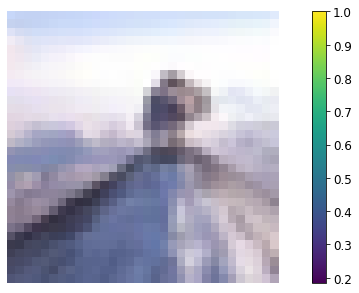

Range of values: min: 0.1843137254901961 - max: 1.0
Image type: float64
Image shape: (32, 32, 3)


In [33]:
display.display_image_prop(X_test_full[0])

In [34]:
from collections import Counter

cnt = Counter(list(y_train_full))
print(cnt)

Counter({64: 68, 71: 65, 63: 65, 85: 64, 53: 62, 56: 61, 66: 61, 4: 61, 11: 60, 90: 59, 80: 59, 33: 59, 57: 59, 51: 58, 40: 58, 42: 57, 62: 56, 84: 55, 35: 55, 7: 55, 87: 54, 78: 54, 38: 54, 68: 54, 79: 54, 58: 54, 28: 53, 8: 53, 73: 53, 67: 53, 30: 53, 5: 53, 3: 53, 19: 52, 59: 52, 41: 52, 37: 52, 31: 51, 21: 51, 55: 51, 99: 51, 48: 51, 70: 50, 65: 50, 45: 50, 20: 50, 98: 50, 50: 50, 44: 50, 60: 50, 52: 49, 49: 49, 83: 49, 34: 49, 26: 49, 54: 49, 16: 49, 24: 48, 14: 48, 36: 48, 43: 48, 69: 48, 94: 48, 32: 48, 10: 48, 29: 47, 89: 47, 15: 47, 46: 47, 77: 47, 0: 46, 27: 46, 95: 46, 61: 46, 91: 46, 86: 45, 82: 45, 76: 45, 72: 45, 18: 45, 2: 45, 25: 45, 1: 44, 92: 44, 23: 43, 96: 43, 97: 43, 93: 43, 12: 43, 39: 42, 74: 42, 22: 42, 88: 42, 13: 42, 47: 41, 81: 40, 9: 38, 75: 38, 17: 34, 6: 34})


In [35]:
# sorted(cnt)
data = [(k, l) for k, l in sorted([(i, j) for i, j in cnt.items()], reverse=False)]
value = [v[0] for v in data]
count = [v[1] for v in data]

In [10]:
print(value)
print(count)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[46, 44, 45, 53, 61, 53, 34, 55, 53, 38, 48, 60, 43, 42, 48, 47, 49, 34, 45, 52, 50, 51, 42, 43, 48, 45, 49, 46, 53, 47, 53, 51, 48, 59, 49, 55, 48, 52, 54, 42, 58, 52, 57, 48, 50, 50, 47, 41, 51, 49, 50, 58, 49, 62, 49, 51, 61, 59, 54, 52, 50, 46, 56, 65, 68, 50, 61, 53, 54, 48, 50, 65, 45, 53, 42, 38, 45, 47, 54, 54, 59, 40, 45, 49, 55, 64, 45, 54, 42, 47, 59, 46, 44, 43, 48, 46, 43, 43, 50, 51]


C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


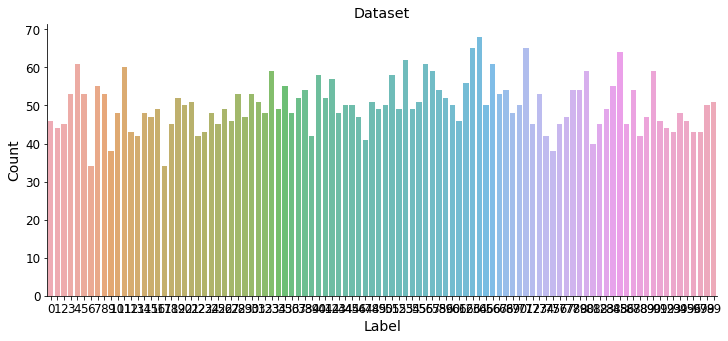

In [11]:
from matplotlib.pyplot import plot
import seaborn as sns

sns.barplot(value, count, alpha=0.8)
plt.title('Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
sns.despine()
plt.show()

In [12]:
### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, Callback

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40)
###

### Model saving
model_saving_encoder = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=ckpt_dir_encoder + "/val_mse={val_mse:.4f}_mse={mse:.4f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor="val_mse",
    save_weights_only=True,
    mode="min",
    verbose=1,
)


###

### Callback class
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        starting_lr = self.model.optimizer.lr
        actual_lr = self.model.optimizer._decayed_lr(tf.float32)
        tf.print("Starting Learning Rate = ", starting_lr)
        tf.print("Actual Learning Rate = ", actual_lr)


my_callback = MyCallback()

###

### init callbacks
callbacks_encoder = [
    model_saving_encoder,
    early_stopping,
    my_callback
]

In [13]:
def get_uncompiled_model_encoder():
    stacked_encoder = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-1"),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-2"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-3"),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-4"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-5"),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-6"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(name="flatten1")
    ])
    stacked_decoder = tf.keras.models.Sequential([
        tf.keras.layers.Reshape([32, 32, 1], input_shape=[1024]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, padding="SAME", activation="selu",
                                        kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(3, kernel_size=3, padding="SAME", activation="sigmoid", kernel_initializer="he_normal"),
    ])
    # stacked_encoder = keras.models.Sequential([
    #     keras.layers.Input([32, 32, 3]),
    #     keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    #     keras.layers.MaxPool2D(pool_size=2),
    #     keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    #     keras.layers.MaxPool2D(pool_size=2),
    #     keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    #     keras.layers.MaxPool2D(pool_size=2)
    # ])
    # # stacked_encoder.summary()
    # stacked_decoder = keras.models.Sequential([
    #     keras.layers.Conv2DTranspose(32, kernel_size=1, strides=2, padding="VALID", activation="selu",
    #                                  input_shape=[4, 4, 64]),
    #     keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    #     keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    #     keras.layers.Reshape([32, 32, 3])
    # ])
    stacked_ae = tf.keras.models.Sequential([stacked_encoder, stacked_decoder])
    # return
    return stacked_ae

In [9]:
def make_or_restore_model_weights_only_uncompiled(model_create, ckpt_dir):
    model = model_create()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(ckpt_dir)
    if latest:
        model.load_weights(latest)
        print("Restoring from", latest)
    return model


In [16]:
# model_encoder = get_uncompiled_model_encoder()
model_encoder = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_encoder, ckpt_dir_encoder)

Restoring from ./ckpt/img_encoder\val_mse=0.0025_mse=0.0027_ckpt=14


In [16]:
# wg = []
# for layer in model_encoder.layers:
#     if layer.name.startswith("encoder"):
#         wg = layer.get_weights()

In [17]:
#Optimizer
nadam = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)  #0.0005

#Loss
mse = 'mse'
model_encoder.compile(loss=mse,
                      optimizer=nadam,
                      metrics=[mse])

In [17]:
history = model_encoder.fit(X_train_unlb,
                            X_train_unlb,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_valid_unlb, X_valid_unlb),
                            callbacks=callbacks_encoder)

Epoch 1/20


KeyboardInterrupt: 

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

NameError: name 'history' is not defined

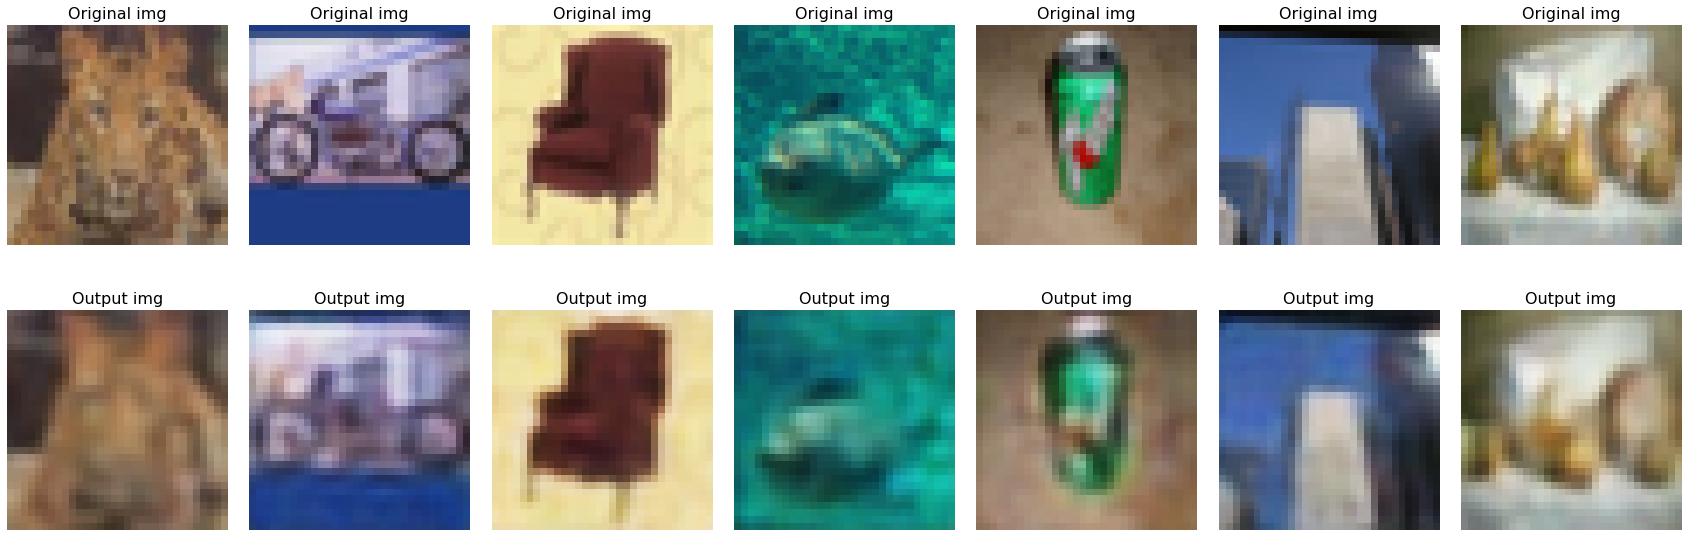

In [18]:
img_no = 7
img = X_valid_unlb[:img_no]
predictions_list = model_encoder.predict(img)
display.display_multiple_images(images=[img,predictions_list],
                                titles=[["Original img"]*img_no,["Output img"]*img_no],
                                figure_size=(30,10))


## Transfer Learning

In [35]:
def get_uncompiled_model_predict():
    stacked_encoder = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-1"),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-2"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-3"),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-4"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-5"),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-6"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(name="flatten1")
    ])
    stack_predict = keras.models.Sequential([
        tf.keras.layers.Input(shape=[1024]),
        # tf.keras.layers.Dense(1024, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(n_classes, activation="softmax", name="output")
    ])

    stacked_model = tf.keras.models.Sequential([stacked_encoder, stack_predict])
    return stacked_model

In [20]:
def transfer_load_enc():
    # load model
    model_enc_tmp = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_encoder, ckpt_dir_encoder)
    # Modify encoder layer name -> easy to do transfer learning
    model_enc_tmp.layers[0]._name = str("encoder")

    # Create predict model
    model_predict = get_uncompiled_model_predict()
    # Modify encoder layer name -> easy to do transfer learning
    model_predict.layers[0]._name = str("encoder")
    #Transfer weights
    model_predict.get_layer("encoder").set_weights(model_enc_tmp.get_layer("encoder").get_weights())

    return model_predict


In [21]:
val_monitor = 'val_sparse_categorical_accuracy'
mode ="max"
### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, Callback

# configure early stopping
early_stopping = EarlyStopping(monitor=val_monitor, patience=40)
###

### Model saving
model_saving_predict = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=ckpt_dir_predict + "/val_acc={val_sparse_categorical_accuracy:.4f}_acc={sparse_categorical_accuracy:.4f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor=val_monitor,
    save_weights_only=True,
    mode=mode,
    verbose=1,
)
###

### Callback class
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        starting_lr = self.model.optimizer.lr
        actual_lr = self.model.optimizer._decayed_lr(tf.float32)
        tf.print("Starting Learning Rate = ", starting_lr)
        tf.print("Actual Learning Rate = ", actual_lr)


my_callback = MyCallback()

###

### init callbacks
callbacks_encoder = [
    model_saving_predict,
    # early_stopping,
    my_callback
]

In [22]:
model_predict = transfer_load_enc()
# print(model_predict.get_layer("encoder").get_weights())

Restoring from ./ckpt/img_encoder\val_mse=0.0025_mse=0.0027_ckpt=14


In [61]:
# Freeze the encoder at first
model_predict.get_layer("encoder").trainable = False


In [ ]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, random_state=100, test_size=0.1)

In [63]:
#Optimizer
nadam = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)  #0.0005
sgd = keras.optimizers.SGD(lr=0.0002, decay=(10 * 1e-5), momentum=0.95)
#Loss
# cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cce = tf.keras.losses.CategoricalCrossentropy()
scc=keras.losses.SparseCategoricalCrossentropy(),


#Metric
acc = 'accuracy'
cat_acc = tf.keras.metrics.categorical_accuracy
sca=keras.metrics.SparseCategoricalAccuracy()

model_predict.compile(loss=scc,
                      optimizer=sgd,
                      metrics=sca)

In [42]:
# model_predict = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_predict, ckpt_dir_predict)

Restoring from ./ckpt/predict\val_acc=0.1067_acc=0.0756_ckpt=67


In [64]:
history = model_predict.fit(X_train,
                            y_train,
                            epochs=400,
                            batch_size=16,
                            validation_split=0.2,
                            callbacks=callbacks_encoder
                            )

Epoch 1/400
219/225 [============================>.] - ETA: 0s - loss: 8.5501 - sparse_categorical_accuracy: 0.0114     
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.01000, saving model to ./ckpt/predict\val_acc=0.0100_acc=0.0114_ckpt=1
Starting Lea

<AxesSubplot:>

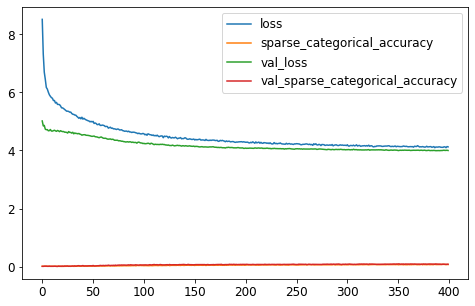

In [65]:
pd.DataFrame(history.history).plot(figsize=(8, 5))


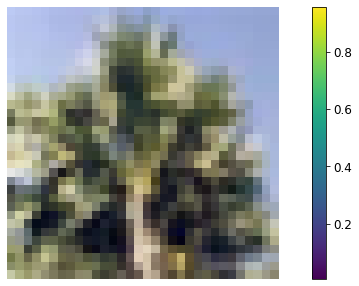

Range of values: min: 0.00784313725490196 - max: 0.9568627450980393
Image type: float64
Image shape: (32, 32, 3)


In [66]:
display.display_image_prop(X_test[1])

In [70]:
model_predict.evaluate(X_test,y_test)

16/16 [==============================] - 0s 2ms/step - loss: 4.0951 - sparse_categorical_accuracy: 0.0800


[4.095147609710693, 0.07999999821186066]

## Train again

### Load Model


In [71]:
val_monitor = 'val_sparse_categorical_accuracy'
mode ="max"
### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, Callback

# configure early stopping
early_stopping = EarlyStopping(monitor=val_monitor, patience=25)
###

### Model saving
model_saving_predict = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=ckpt_dir_predict_retrained + "/val_acc={val_sparse_categorical_accuracy:.4f}_acc={sparse_categorical_accuracy:.4f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor=val_monitor,
    save_weights_only=True,
    mode=mode,
    verbose=1,
)


###

### Callback class
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        starting_lr = self.model.optimizer.lr
        actual_lr = self.model.optimizer._decayed_lr(tf.float32)
        tf.print("Starting Learning Rate = ", starting_lr)
        tf.print("Actual Learning Rate = ", actual_lr)


my_callback = MyCallback()

###

### init callbacks
callbacks_encoder = [
    model_saving_predict,
    early_stopping,
    my_callback
]

### With Transfer Loading

In [82]:
model_predict_retrained = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_predict, ckpt_dir_predict_retrained)
# model_predict_retrained = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_predict, ckpt_dir_predict)

Restoring from ./ckpt/pred_ret\val_acc=0.1722_acc=0.1481_ckpt=133


In [ ]:
model_predict_retrained = model_predict
model_predict_retrained.get_layer("encoder").trainable = True

In [84]:
#Optimizer
nadam = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)  #0.0005
sgd = keras.optimizers.SGD(lr=0.00002, decay=(5 * 1e-5), momentum=0.95)
#Loss
# cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cce = tf.keras.losses.CategoricalCrossentropy()
scc=keras.losses.SparseCategoricalCrossentropy(),


#Metric
acc = 'accuracy'
cat_acc = tf.keras.metrics.categorical_accuracy
sca=keras.metrics.SparseCategoricalAccuracy()

model_predict_retrained.compile(loss=scc,
                      optimizer=sgd,
                      metrics=sca)

In [79]:
history = model_predict_retrained.fit(X_train,
                            y_train,
                            epochs=300,
                            batch_size=16,
                            validation_split=0.2,
                            callbacks=callbacks_encoder
                            )

Epoch 1/300
213/225 [===========================>..] - ETA: 0s - loss: 3.9397 - sparse_categorical_accuracy: 0.0992

KeyboardInterrupt: 

<AxesSubplot:>

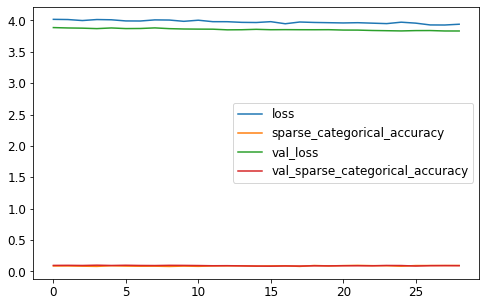

In [78]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
#

In [85]:
model_predict_retrained.evaluate(X_test,y_test)


16/16 [==============================] - 0s 2ms/step - loss: 3.7918 - sparse_categorical_accuracy: 0.1540


[3.791811943054199, 0.15399999916553497]

### Starting Clean

In [36]:
def get_uncompiled_model_predict():
    stacked_encoder = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-1"),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-2"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-3"),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-4"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-5"),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-6"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-7"),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", kernel_initializer="he_normal",
                               name="base-8"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(name="flatten1")
    ])
    # stack_predict = keras.models.Sequential([
    #     tf.keras.layers.Input(shape=[1024]),
    #     # tf.keras.layers.Dense(1024, activation="selu", kernel_initializer="he_normal"),
    #     tf.keras.layers.Dropout(0.4),
    #     tf.keras.layers.Dense(256, activation="selu", kernel_initializer="he_normal"),
    #     tf.keras.layers.Dropout(0.4),
    #     tf.keras.layers.Dense(512, activation="selu", kernel_initializer="he_normal"),
    #     tf.keras.layers.Dropout(0.4),
    #     tf.keras.layers.Dense(n_classes, activation="softmax", name="output")
    # ])
    stack_predict = keras.models.Sequential([
        tf.keras.layers.Input(shape=[128]),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation="selu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(n_classes, activation="softmax", name="output")
    ])
    stacked_model = tf.keras.models.Sequential([stacked_encoder, stack_predict])
    return stacked_model

In [37]:
aug_types=[0,1,2,3]
# Prepare data augment
X_full = []
y_full = []
for type in aug_types:
    X_full.extend([(path, type) for path in X_train_full])
    y_full.extend([label for label in y_train_full])

In [38]:
X_train_full2, X_test_full2, y_train_full2, y_test_full2 = train_test_split(X_full, y_full, random_state=42,
                                                                        test_size=0.25)

In [39]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for fitting - one batch at a time'

    def __init__(self, X_dataset, labels, batch_size=32, dim=(158, 158),
                 transforms=None, shuffle=True):
        'Initialization'
        self.X_dataset = copy.deepcopy(X_dataset)
        self.labels = copy.deepcopy(labels)
        self.batch_size = batch_size
        self.dim = dim
        self.transforms = transforms
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        batches_per_epoch = int(np.floor(len(self.X_dataset) / self.batch_size))
        return batches_per_epoch

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i == self.__len__() - 1:
                self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X_dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Find list of paths
        X_dataset_temp = [self.X_dataset[k] for k in indexes]
        # Find labels
        y = [self.labels[k] for k in indexes]
        'Generates data containing batch_size samples'  # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, img_prop in enumerate(X_dataset_temp):
            img = img_prop[0]
            aug_type = img_prop[1]
            # Store sample
            X[i,] = self.__preprocess_image(img, aug_type)
        return X, np.array(y)

    def __preprocess_image(self, path, aug_type):
        'Preprocess the images'
        img = self.transforms(path, aug_type)
        return img

def preprocess_img(img, aug_type):
    img = augment(img, aug_type)  # augment the images
    return img

def augment(img, aug_type):
    if aug_type == 0:
        return img
    elif aug_type == 1:
        return tf.image.random_flip_left_right(img)
    elif aug_type == 2:
        return tf.image.flip_up_down(img)
    elif aug_type == 3:
        return tf.image.rot90(img)
    return img


In [44]:
model_predict_retrained = get_uncompiled_model_predict()

In [45]:
val_monitor = 'val_sparse_categorical_accuracy'
mode ="max"
### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, Callback

# configure early stopping
early_stopping = EarlyStopping(monitor=val_monitor, patience=25)
###

### Model saving
model_saving_predict = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=ckpt_dir_predict_retrained + "/val_acc={val_sparse_categorical_accuracy:.4f}_acc={sparse_categorical_accuracy:.4f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor=val_monitor,
    save_weights_only=True,
    mode=mode,
    verbose=1,
)


###

### Callback class
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        starting_lr = self.model.optimizer.lr
        actual_lr = self.model.optimizer._decayed_lr(tf.float32)
        tf.print("Starting Learning Rate = ", starting_lr)
        tf.print("Actual Learning Rate = ", actual_lr)


my_callback = MyCallback()

###

### init callbacks
callbacks_clean = [
    model_saving_predict,
    early_stopping,
    my_callback
]

In [46]:
#Optimizer
nadam = tf.keras.optimizers.Nadam(lr=0.0002, beta_1=0.9, beta_2=0.999)  #0.0005
sgd = keras.optimizers.SGD(lr=0.00002, decay=(5 * 1e-5), momentum=0.95)
#Loss
# cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cce = tf.keras.losses.CategoricalCrossentropy()
scc=keras.losses.SparseCategoricalCrossentropy(),


#Metric
acc = 'accuracy'
cat_acc = tf.keras.metrics.categorical_accuracy
sca=keras.metrics.SparseCategoricalAccuracy()

model_predict_retrained.compile(loss=scc,
                      optimizer=nadam,
                      metrics=sca)

In [48]:
params = {'batch_size': 16,
          'dim': (32, 32, 3),
          'shuffle': True,
          'transforms': preprocess_img}
training_generator_batch = DataGenerator(X_dataset=X_train_full2, labels=y_train_full2, **params)
validation_generator_batch = DataGenerator(X_dataset=X_test_full2, labels=y_test_full2, **params)
history = model_predict_retrained.fit(
    x=training_generator_batch,
    validation_data=validation_generator_batch,
    epochs=100,
    callbacks=callbacks_clean
)
pd.DataFrame(history.history).plot(figsize=(8, 5))

Epoch 1/100
467/468 [============================>.] - ETA: 0s - loss: 5.2137 - sparse_categorical_accuracy: 0.0363    

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
#

In [86]:
model_predict_retrained.evaluate(X_test,y_test)


##% md
# Submission

16/16 [==============================] - 0s 5ms/step - loss: 3.7918 - sparse_categorical_accuracy: 0.1540


[3.791811943054199, 0.15399999916553497]

In [20]:
model_predict_retrained = make_or_restore_model_weights_only_uncompiled(get_uncompiled_model_predict, ckpt_dir_predict_retrained)

Restoring from ./ckpt/pred_ret\val_acc=0.3273_acc=0.3436_ckpt=32


In [22]:
predicts = model_predict_retrained.predict(X_test_full)
predictions = [np.argmax(pred) for pred in predicts]

In [23]:
print(predictions)

[40, 37, 34, 90, 71, 34, 80, 4, 71, 83, 87, 80, 58, 69, 40, 65, 0, 15, 70, 53, 61, 39, 48, 59, 21, 94, 37, 8, 34, 98, 20, 61, 24, 73, 96, 27, 70, 21, 94, 33, 38, 72, 30, 99, 89, 11, 57, 16, 3, 56, 35, 29, 9, 94, 2, 36, 71, 52, 42, 30, 16, 33, 89, 34, 70, 92, 34, 21, 51, 84, 66, 51, 23, 51, 67, 32, 82, 22, 35, 0, 71, 36, 54, 19, 73, 81, 99, 42, 5, 73, 66, 40, 4, 46, 58, 4, 72, 45, 90, 11, 42, 53, 47, 65, 4, 69, 12, 37, 53, 95, 5, 25, 67, 83, 9, 69, 8, 34, 0, 56, 90, 90, 38, 70, 33, 94, 21, 64, 92, 91, 86, 16, 70, 63, 21, 59, 60, 64, 47, 73, 63, 98, 52, 15, 55, 95, 86, 66, 51, 58, 58, 37, 37, 59, 9, 63, 37, 84, 24, 42, 36, 27, 75, 0, 55, 47, 54, 93, 34, 83, 40, 43, 33, 16, 30, 53, 67, 73, 14, 5, 31, 3, 48, 98, 55, 3, 94, 95, 43, 70, 86, 7, 83, 83, 94, 24, 82, 42, 18, 87, 6, 95, 68, 44, 79, 71, 24, 52, 55, 52, 30, 2, 49, 97, 37, 33, 2, 95, 83, 21, 16, 49, 69, 2, 58, 72, 0, 33, 78, 12, 95, 57, 85, 24, 46, 54, 31, 57, 62, 38, 69, 24, 64, 21, 86, 62, 51, 64, 33, 39, 27, 16, 80, 61, 77, 66, 2

In [24]:
indexes = []
for i in range(len(predictions)):
    indexes.append(i)

In [25]:
print(indexes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [26]:
import pandas

df = pandas.DataFrame(data={"index": indexes, "label": predictions})
df.to_csv("./sub-2-class.csv", sep=',', index=False)
